<code>calculate_VRILE_counts.ipynb</code>. Calculates the number of VRILEs as a function of month for each model at a given lead time. 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import seaborn as sns
from S2S_sea_ice_preprocess import load_model, create_aggregate_regions, create_model_climatology, create_obs_climatology
from S2S_sea_ice_VRILEs import get_VRILE_days

In [2]:
model_names_ALL = ['ecmwf','ncep','ukmo','metreofr']
obs_names_ALL = ['NSIDC_0079','NSIDC_0051']
COMMON_RF = True 
vrile_thresh = 0.05
vrile_thresh_str = '05'
seas_str = 'ALL'
seas_sel = [1,2,3,4,5,6,7,8,9,10,11,12]
nday_change = 5

Load data from all S2S models

In [3]:
SIE_df_ALL = pd.DataFrame()
SIE_df_weekly_ALL = pd.DataFrame()
for model_name in model_names_ALL:
    print('loading ',model_name)
    # Load
    SIE = load_model(model_name)
    print('loaded ',model_name)
    # Create aggregate regions
    SIE = create_aggregate_regions(SIE)
    print('combined regions')
    # Take ensemble mean and get lead time in days
    SIE_ens_mean = SIE.mean(dim='ensemble')
    regions = SIE.region_names
    lead_days = SIE.fore_time.dt.days
    # Convert to dataframe, rename some columns, and get the date of the forecast by adding the fore_time to init_date
    SIE_df = SIE_ens_mean.to_dataframe().reset_index()
    SIE_df['valid date'] = SIE_df['init_time'] + SIE_df['fore_time']
    SIE_df = SIE_df.rename(columns={'region_names':'region',
                               'fore_time':'lead time (days)',
                               'init_time':'init date',
                               'Extent':'SIE'})
    SIE_df = create_model_climatology(SIE_df,7)
    SIE_df['model name'] = model_name
    
# Create climatology
    SIE_df_ALL = SIE_df_ALL.append(SIE_df)

loading  ecmwf
loading files from  /home/disk/sipn/nicway/data/model/ecmwf/reforecast/sipn_nc_agg_commonland/
<xarray.Dataset>
Dimensions:       (ensemble: 10, fore_time: 46, init_time: 2080, nregions: 15)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * ensemble      (ensemble) int32 0 1 2 3 4 5 6 7 8 9
  * fore_time     (fore_time) timedelta64[ns] 0 days 1 days ... 44 days 45 days
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * init_time     (init_time) datetime64[ns] 1998-08-06 ... 2018-08-01
Data variables:
    Extent        (ensemble, init_time, fore_time, nregions) float64 dask.array<chunksize=(10, 1, 46, 15), meta=np.ndarray>
loaded  ecmwf
combined regions


/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


loading  ncep
loading files from  /home/disk/sipn/nicway/data/model/ncep/reforecast/sipn_nc_agg_commonland/
<xarray.Dataset>
Dimensions:       (ensemble: 3, fore_time: 43, init_time: 4523, nregions: 15)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * ensemble      (ensemble) int32 0 1 2
  * fore_time     (fore_time) timedelta64[ns] 1 days 2 days ... 42 days 43 days
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * init_time     (init_time) datetime64[ns] 1999-01-01 ... 2010-12-31
Data variables:
    Extent        (ensemble, init_time, fore_time, nregions) float64 dask.array<chunksize=(3, 16, 43, 15), meta=np.ndarray>
loaded  ncep
combined regions


/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


loading  ukmo
loading files from  /home/disk/sipn/nicway/data/model/ukmo/reforecast/sipn_nc_agg_commonland/
<xarray.Dataset>
Dimensions:       (ensemble: 6, fore_time: 60, init_time: 1008, nregions: 15)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * ensemble      (ensemble) int32 0 1 2 3 4 5
  * fore_time     (fore_time) timedelta64[ns] 0 days 1 days ... 58 days 59 days
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * init_time     (init_time) datetime64[ns] 1995-01-01 ... 2015-12-25
Data variables:
    Extent        (ensemble, init_time, fore_time, nregions) float64 dask.array<chunksize=(6, 1, 60, 15), meta=np.ndarray>
loaded  ukmo
combined regions
loading  metreofr
loading files from  /home/disk/sipn/nicway/data/model/metreofr/reforecast/sipn_nc_agg_commonland/
<xarray.Dataset>
Dimensions:       (ensemble: 9, fore_time: 47, init_time: 834, nregions: 15)
Coordinates:
    region_names  (nregions) object dask.

Load both sets of observations

In [4]:
obs_SIE_all = pd.DataFrame()
for i_obs_name in obs_names_ALL:
    if i_obs_name == 'NSIDC_0051':
        obs_type = 'sipn_nc_yearly_agg'
    else:
        obs_type = 'sipn_nc_yearly_agg_commonland'
    filepath = '/home/disk/sipn/nicway/data/obs/{model_name}/{model_type}/'.format(model_name=i_obs_name,
                                                                              model_type=obs_type)
    obs_filenames = xr.open_mfdataset(filepath+'/*.nc',combine='by_coords')
    print('opening ',obs_filenames)
    obs_SIE = obs_filenames.Extent
    obs_regions = obs_filenames.nregions
    obs_region_names = obs_filenames['region_names'].values
    # Drop region names and re-add as a non-dask.array object.  This is stupid but oh well
    obs_SIE = obs_SIE.drop('region_names')
    obs_SIE["region_names"] = ("nregions",obs_region_names)
    print('{i_obs} loaded'.format(i_obs=i_obs_name))
    # 
    obs_SIE = create_aggregate_regions(obs_SIE)
    obs_SIE = obs_SIE.to_dataframe().reset_index()
    obs_SIE = obs_SIE.rename(columns={'Extent':'SIE','region_names':'region','time':'valid date'})
    #
    if COMMON_RF == True:
        obs_SIE = obs_SIE[pd.to_datetime(obs_SIE['valid date']).dt.year.isin(np.arange(1999,2015))]
        obs_SIE = create_obs_climatology(obs_SIE)
        time_str = 'COMMON_RF'
        print('common reforecast')
    else:
        time_str = 'FULL_PERIOD'
        obs_SIE = create_obs_climatology(obs_SIE)
        print('full period')
    print('observed climatology created')
    obs_SIE['model name'] = i_obs_name
    obs_SIE_all = obs_SIE_all.append(obs_SIE)

opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11627)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2020-10-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
NSIDC_0079 loaded
common reforecast
observed climatology created
opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11261)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2019-10-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
NSIDC_0051 loaded
common reforecast
observed climatology created


Get VRILE days only for observations based on <code>vrile_thresh</code> and <code>seas_sel</code>


In [6]:
obs_SIE_VRILE = pd.DataFrame()
obs_SIE_anom_VRILE = pd.DataFrame()
for i_obs in obs_names_ALL:
    i_obs_SIE = obs_SIE_all.set_index(['model name']).loc[i_obs].reset_index()
    [obs_SIE_VRILE_only, obs_SIE_anom_VRILE_only, obs_SIE_NO_VRILE, obs_SIE_anom_NO_VRILE] = get_VRILE_days(i_obs_SIE,vrile_thresh,nday_change,seas_sel)
    obs_SIE_VRILE_only['model name'] = i_obs
    obs_SIE_VRILE = obs_SIE_VRILE.append(obs_SIE_VRILE_only)
    obs_SIE_anom_VRILE_only['model name'] = i_obs
    obs_SIE_anom_VRILE = obs_SIE_anom_VRILE.append(obs_SIE_anom_VRILE_only)

Get VRILE days only for models based on <code>vrile_thresh</code> and <code>seas_sel</code>.  Models need to be sorted by model name and lead time

In [8]:
week_length = 7
SIE_df_ALL['lead time (weeks)'] = np.floor(SIE_df_ALL['lead time (days)'].dt.days/week_length)
SIE_df_ALL_sel = SIE_df_ALL.set_index(['model name','lead time (weeks)'])
model_SIE_VRILE = pd.DataFrame()
model_SIE_anom_VRILE = pd.DataFrame()
#weeks = SIE_df_ALL['lead time (weeks)'].unique().tolist()
for i_model in model_names_ALL:
    i_SIE = SIE_df_ALL_sel.loc[i_model]
    mod_weeks = i_SIE.index.get_level_values(level=0).unique().tolist()
    print('running ',i_model)
    for iweek in mod_weeks:
        i_SIE_k = i_SIE.loc[iweek]
        [imod_SIE_VRILE_only, imod_SIE_anom_VRILE_only, imod_SIE_NO_VRILE, imod_SIE_anom_NO_VRILE] = get_VRILE_days(i_SIE_k,vrile_thresh,nday_change,seas_sel)
        imod_SIE_VRILE_only['model name'] = i_model
        imod_SIE_VRILE_only['lead time (weeks)'] = iweek
        model_SIE_VRILE = model_SIE_VRILE.append(imod_SIE_VRILE_only)
        imod_SIE_anom_VRILE_only['model name'] = i_model
        imod_SIE_anom_VRILE_only['lead time (weeks)'] = iweek
        model_SIE_anom_VRILE = model_SIE_anom_VRILE.append(imod_SIE_anom_VRILE_only)

running  ecmwf


/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
/home/disk/sipn/m

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
/home/disk/sipn/m

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
/home/disk/sipn/m

running  ncep


/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
/home/disk/sipn/m

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
/home/disk/sipn/m

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
/home/disk/sipn/m

running  ukmo


/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
/home/disk/sipn/m

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
/home/disk/sipn/m

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
/home/disk/sipn/m

running  metreofr


/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
/home/disk/sipn/m

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
/home/disk/sipn/m

/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/code/notebooks/S2S_sea_ice_VRILEs.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
/home/disk/sipn/m

Get the number of VRILE dyas as a function of month, region, and model by using <code>groupby.count()</code>

In [10]:
obs_SIE_VRILE_ct = obs_SIE_VRILE.groupby(['model name','region',pd.to_datetime(obs_SIE_VRILE['valid date']).dt.month]).count().unstack(fill_value=0).stack()
obs_SIE_anom_VRILE_ct = obs_SIE_anom_VRILE.groupby(['model name','region',pd.to_datetime(obs_SIE_anom_VRILE['valid date']).dt.month]).count().unstack(fill_value=0).stack()
#
model_SIE_VRILE_ct = model_SIE_VRILE.groupby(['model name','region','lead time (weeks)',
                                             pd.to_datetime(model_SIE_VRILE['valid date']).dt.month]).count().unstack(fill_value=0).stack()
model_SIE_anom_VRILE_ct = model_SIE_anom_VRILE.groupby(['model name','region','lead time (weeks)',
                                             pd.to_datetime(model_SIE_anom_VRILE['valid date']).dt.month]).count().unstack(fill_value=0).stack()

Get percentage of VRILE days in each month

In [35]:
obs_SIE_VRILE_ct_pct = 100*(obs_SIE_VRILE_ct/obs_SIE_VRILE_ct.sum(level=(0,1)))
obs_SIE_anom_VRILE_ct_pct = 100*(obs_SIE_anom_VRILE_ct/obs_SIE_anom_VRILE_ct.sum(level=(0,1)))
#
model_SIE_VRILE_ct_pct = 100*(model_SIE_VRILE_ct/model_SIE_VRILE_ct.sum(level=(0,1,2)))
model_SIE_anom_VRILE_ct_pct = 100*(model_SIE_anom_VRILE_ct/model_SIE_anom_VRILE_ct.sum(level=(0,1,2)))


Quick sanity check

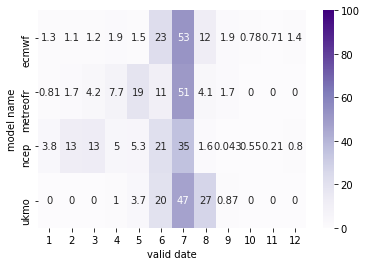

In [36]:
obs_SIE_VRILE_ct_plt = model_SIE_VRILE_ct_pct.rename(columns={'valid date':'valid date full'})
test_obs = obs_SIE_VRILE_ct_plt.xs('panArctic',level=1).reset_index()
test_obs_piv = pd.pivot_table(test_obs,columns='valid date',index='model name',values='SIE')
sns.heatmap(test_obs_piv,vmin=0,vmax=100,cmap='Purples',annot=True)

Combine obs and models into single dataframes

In [39]:
obs_SIE_VRILE_ct_ALL = obs_SIE_VRILE_ct[['SIE','d_SIE']]
obs_SIE_VRILE_ct_ALL[['SIE anom','d_SIE anom']] = obs_SIE_anom_VRILE_ct[['SIE','d_SIE']]
obs_SIE_VRILE_ct_ALL[['SIE pct','d_SIE pct']] = obs_SIE_VRILE_ct_pct[['SIE','d_SIE']]
obs_SIE_VRILE_ct_ALL[['SIE anom pct','d_SIE anom pct']] = obs_SIE_anom_VRILE_ct_pct[['SIE','d_SIE']]
#obs_SIE_VRILE_ct_pct

In [40]:
model_SIE_VRILE_ct_ALL = model_SIE_VRILE_ct[['SIE','d_SIE']]
model_SIE_VRILE_ct_ALL[['SIE anom','d_SIE anom']] = model_SIE_anom_VRILE_ct[['SIE','d_SIE']]
model_SIE_VRILE_ct_ALL[['SIE pct','d_SIE pct']] = model_SIE_VRILE_ct_pct[['SIE','d_SIE']]
model_SIE_VRILE_ct_ALL[['SIE anom pct','d_SIE anom pct']] = model_SIE_anom_VRILE_ct_pct[['SIE','d_SIE']]


In [43]:
fpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/COMMON_LAND_MASK/data/'
fname_save_model = fpath_save+'S2S_model_VRILE_counts_{nday_change}day_change_VRILE{vrile_str}_VRILE_seas_{seas_str}.csv'.format(nday_change=nday_change,
                                                                                                  vrile_str=vrile_thresh_str,
                                                                                                  seas_str=seas_str)
#
fname_save_obs = fpath_save+'obs_VRILE_counts_{nday_change}day_change_VRILE{vrile_str}_VRILE_seas_{seas_str}.csv'.format(nday_change=nday_change,
                                                                                                  vrile_str=vrile_thresh_str,
                                                                                                  seas_str=seas_str)
#
model_SIE_VRILE_ct_ALL.to_csv(fname_save_model)
obs_SIE_VRILE_ct_ALL.to_csv(fname_save_obs)